In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm

import scanpy as sc

from causarray import *

import os
path_data = 'data/lupus/'
path_result = 'results/Lupus/'
os.makedirs(path_result, exist_ok=True)

# Preprocess and save data

In [2]:
adata = sc.read_h5ad('data/lupus/raw.h5ad')
print(adata)

# 261 individuals
adata = adata[adata.obs['pop_cov'].isin(['Asian', 'European']),:]
# 256 individuals
adata.obs['cg_pop_cov'] = adata.obs['cg_cov'].astype(str) + '-' + adata.obs['pop_cov'].astype(str)
adata.obs['cg_pop_cov'] = adata.obs['cg_pop_cov'].astype("category")

gene_names = np.array(adata.var_names, dtype=str)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs.groupby(['ind_cov']).count().shape[0]

AnnData object with n_obs × n_vars = 1263676 × 32738
    obs: 'SLE_status', 'ind_cov', 'batch_cov', 'pop_cov', 'cg_cov', 'ct_cov', 'Age', 'Sex', 'Processing_Cohort', 'L3'


256

In [3]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
col_covariate = ['Sex','Processing_Cohort','pop_cov','SLE_status']

n_hvg = 2000
for celltype in adata.obs['cg_cov'].unique():
    idx = adata.obs['cg_cov'] == celltype
    _adata = adata[idx].copy()
    
    sc.pp.highly_variable_genes(_adata, n_top_genes=n_hvg)
    gene_names = _adata.var.index[_adata.var['highly_variable']]
    
    count = _adata.raw.X[:,np.in1d(_adata.raw.var_names.tolist(), gene_names)]
    
    _df = _adata.obs
    uni_ind = np.unique(_df['ind_cov'])
    
    print(celltype)
    print('\t shape:', _adata.raw.X.shape, len(_adata.raw.var_names))
    print('\t ind:', len(uni_ind))    

    meta = _df.iloc[:,:]
    
    enc = OrdinalEncoder()    
    X = enc.fit_transform(meta[['Sex','pop_cov','SLE_status']])
        
    enc = OneHotEncoder(drop='first')
    _X = enc.fit_transform(meta[['Processing_Cohort']])
    
    X = np.c_[X[:,:-1], _X.toarray(), X[:,-1:]]
    
    Y = count.toarray()
    ind = _df['ind_cov']
    print(Y.shape, X.shape, ind.shape)
    
    with open(path_data + 'data_{}.npz'.format(celltype), 'wb') as f:
        np.savez(f, X=X, Y=Y, ind=ind, gene_names=gene_names)

T4
	 shape: (375885, 32738) 32738
	 ind: 256
(375885, 2000) (375885, 6) (375885,)
cM
	 shape: (302649, 32738) 32738
	 ind: 256
(302649, 2000) (302649, 6) (302649,)
B
	 shape: (149861, 32738) 32738
	 ind: 254
(149861, 2000) (149861, 6) (149861,)
T8
	 shape: (242677, 32738) 32738
	 ind: 256
(242677, 2000) (242677, 6) (242677,)
NK
	 shape: (90190, 32738) 32738
	 ind: 256
(90190, 2000) (90190, 6) (90190,)
ncM
	 shape: (48196, 32738) 32738
	 ind: 256
(48196, 2000) (48196, 6) (48196,)
Prolif
	 shape: (7904, 32738) 32738
	 ind: 255
(7904, 2000) (7904, 6) (7904,)
cDC
	 shape: (18032, 32738) 32738
	 ind: 254
(18032, 2000) (18032, 6) (18032,)
pDC
	 shape: (5206, 32738) 32738
	 ind: 254
(5206, 2000) (5206, 6) (5206,)
PB
	 shape: (1372, 32738) 32738
	 ind: 212
(1372, 2000) (1372, 6) (1372,)
Progen
	 shape: (800, 32738) 32738
	 ind: 215
(800, 2000) (800, 6) (800,)


# Load data

In [4]:
celltypes = ['T4', 'cM', 'B', 'T8', 'NK']
celltype = celltypes[0]


with open(path_data + 'data_{}.npz'.format(celltype), 'rb') as f:
    res = np.load(f, allow_pickle=True)
    W = res['X']
    ind = res['ind']
    gene_names = res['gene_names']
    Y = res['Y']
    W = W * 2 - 1

groups = ind
_ndx = np.argsort(groups)
_id, _pos, g_count  = np.unique(
    groups[_ndx], return_index=True, return_counts=True)

Y = Y[_ndx]
W = W[_ndx]

Yg = np.add.reduceat(Y, _pos, axis=0)
Wg = W[_pos]
Wg = np.c_[np.ones(Wg.shape[0]), np.log(np.sum(Yg, axis=1)),  Wg]
Wg = Wg / np.sqrt(np.sum(Wg**2, 0, keepdims=True)) * np.sqrt(Wg.shape[0])
Wg[:,-1] = (Wg[:,-1]+1)/2

id_genes = np.any(Yg!=0, axis=0) & (np.sum(Yg>0, axis=0)>=10)

W = np.repeat(Wg, g_count, axis=0)
Y = Y[:,id_genes]
Yg = Yg[:,id_genes]
print(Wg.shape, Yg.shape, Yg.shape)

resid = fit_glm(Yg, Wg[:,:-1], np.zeros((Yg.shape[0],0)), family='nb')[-1]
W = Wg[:,:-1]
A = Wg[:,-1]
df_glm_p, df_glm_nb = glm_test(Yg, W, A)
df_glm_p.index = gene_names[id_genes]
df_glm_nb.index = gene_names[id_genes]


(256, 8) (256, 1255) (256, 1255)


# ATE

In [5]:
df_ATE = ATE(Yg, W, A, W[:,:4], B=10000, alpha=0.05, c=0.1, family='nb', penalty='none')
df_ATE.to_csv(path_result+'{}_ATE.csv'.format(celltype), index=False)
df_ATE['rej'].sum()

144.0

# SATE

In [6]:
df_SATE = SATE(Yg, W, A, W[:,:4], B=10000, alpha=0.05, c=0.1, family='nb', penalty='none')
df_SATE.to_csv(path_result+'{}_SATE.csv'.format(celltype), index=False)
df_SATE['rej'].sum()

146.0

# QTE

In [7]:
df_QTE = QTE(
    Yg, W, A, W[:,:4], B=10000, alpha=0.05, c=0.1, family='nb', penalty='none'
    )
df_QTE.to_csv(path_result+'{}_QTE.csv'.format(celltype), index=False)

df_QTE['rej'].sum()

81.0

# SQTE

In [8]:
df_SQTE = SQTE(
    Yg, W, A, W_D=W[:,:4], B=10000, alpha=0.05, c=0.1, family='nb', penalty='none'
    )
df_SQTE.to_csv(path_result+'{}_SQTE.csv'.format(celltype), index=False)
df_SQTE['rej'].sum()

54.0

# Plot

In [9]:
df_ATE = pd.read_csv(path_result+'{}_ATE.csv'.format(celltype))
df_STE = pd.read_csv(path_result+'{}_SATE.csv'.format(celltype))
df_QTE = pd.read_csv(path_result+'{}_QTE.csv'.format(celltype))
df_SQTE = pd.read_csv(path_result+'{}_SQTE.csv'.format(celltype))
df_ATE.index = gene_names[id_genes]
df_STE.index = gene_names[id_genes]
df_QTE.index = gene_names[id_genes]
df_SQTE.index = gene_names[id_genes]

In [10]:
df_ATE['rej'].sum(), df_STE['rej'].sum(), df_QTE['rej'].sum(), df_SQTE['rej'].sum()

(144.0, 146.0, 81.0, 54.0)

In [11]:
np.sum(df_glm_nb['q_values']<0.1), np.sum((df_glm_nb['q_values']<0.1)&(df_ATE['rej']==1)), np.sum((df_glm_nb['q_values']<0.1)&(df_STE['rej']==1)), np.sum((df_glm_nb['q_values']<0.1)&(df_QTE['rej']==1))

(60, 56, 49, 29)

## Upset plot

In [12]:
import upsetplot
from upsetplot import UpSet
from upsetplot import from_indicators

In [13]:
methods = ['ATE','STE','QTE','SQTE']
discoveries = pd.DataFrame(np.c_[df_ATE['rej'], df_STE['rej'], df_QTE['rej'], df_SQTE['rej']
], 
    columns = methods)
discoveries.fillna(0, inplace=True)
discoveries = (discoveries==1)
discoveries = discoveries.loc[np.any(discoveries, axis=1)]

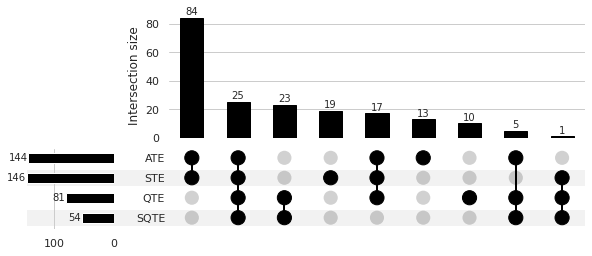

In [14]:
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False})
fig = plt.figure(figsize=(10, 4))
upsetplot.plot(from_indicators(discoveries).groupby(methods[::-1]).count(),
      sort_categories_by='input', sort_by='cardinality',
      fig=fig,  element_size=None, show_counts=True
      )
plt.savefig('figures/Lupus_upset_{}.pdf'.format(celltype), bbox_inches='tight', dpi=300)

## Statistics

In [15]:
import scipy as sp
def summarize(Y, resid, A):
    res_diff = np.r_[
        (np.abs(np.median(resid[A==1]) - (np.median(resid[A==0]))))/1000,
        np.abs(np.mean((resid+Y)[A==1]) - np.mean((resid+Y)[A==0]))/np.std((resid+Y)[A==0]),
        np.abs(np.median((resid+Y)[A==1]) - np.median((resid+Y)[A==0]))/np.std((resid+Y)[A==0])
    ]

    res_overall = np.r_[
        np.mean(Y==0), 
        
    ]

    res = np.r_[res_diff, res_overall]
    return res

idx_list = [
    np.where((df_ATE['rej']==1)&(df_STE['rej']==1)&(df_QTE['rej']==1)&(df_SQTE['rej']==1))[0],
    np.where((df_ATE['rej']!=1)&(df_STE['rej']!=1)&(df_QTE['rej']==1)&(df_SQTE['rej']==1))[0],
    np.where((df_ATE['rej']==1)&(df_STE['rej']==1)&(df_QTE['rej']!=1)&(df_SQTE['rej']!=1))[0]
]

res_all = []
for i, idx in enumerate(idx_list):
    for j in idx:
        res = np.r_[summarize(Yg[:,j], resid[:,j], A), j, i]
        
        res_all.append(res)
res_all = np.array(res_all)    

In [16]:
col_names = ['Absolute difference\nof residual median',
    'Absolute difference\nof fitted response mean',
    'Absolute difference\nof fitted response median',
    'Proportion of\nzero counts', 'j', 'Test']
_df = pd.DataFrame(res_all, columns=col_names)
_df['Test'] = _df['Test'].map(
    {0: 'Common ({})'.format(np.sum(_df['Test']==0)), 1: 'QTE & SQTE only ({})'.format(np.sum(_df['Test']==1)), 
    2: 'ATE & STE only ({})'.format(np.sum(_df['Test']==2))})
_df['count'] = _df.groupby('Test')['Test'].transform('count')

# _df.to_csv(path_result+'{}_summary.csv'.format(gRNA_name), index=False)

print(_df.groupby('Test').median())
_df = _df.melt(id_vars=['j', 'Test'], value_vars=col_names[:-2], value_name='Value', var_name='Metric')

                      Absolute difference\nof residual median  \
Test                                                            
ATE & STE only (84)                                  0.009100   
Common (25)                                          0.363351   
QTE & SQTE only (23)                                 0.012070   

                      Absolute difference\nof fitted response mean  \
Test                                                                 
ATE & STE only (84)                                       0.493550   
Common (25)                                               0.677256   
QTE & SQTE only (23)                                      0.376370   

                      Absolute difference\nof fitted response median  \
Test                                                                   
ATE & STE only (84)                                         0.289310   
Common (25)                                                 0.352550   
QTE & SQTE only (23)               

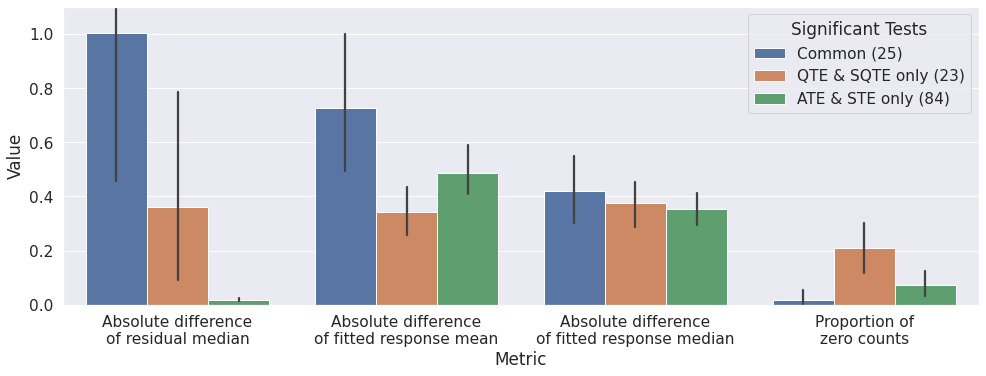

In [17]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(14,6))

sns.barplot(_df, y='Value', x='Metric', hue='Test', ax=ax)
plt.ylim([0,1.1])

ax.legend(title='Significant Tests')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('figures/lupus_{}_metric.pdf'.format(celltype), bbox_inches='tight', pad_inches=0, dpi=300)

## Distributions

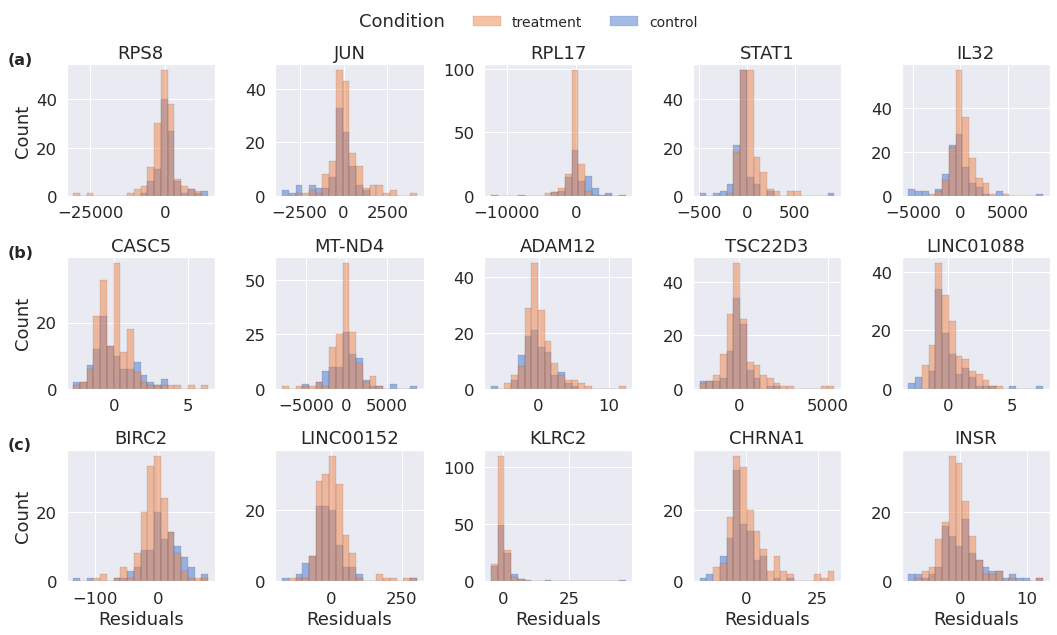

In [18]:
from matplotlib.colors import to_rgba
n_col = 5
colors = [
    sns.color_palette("muted")[1], sns.color_palette("muted")[0]
]
sns.set(font_scale=1.5)
fig, axes = plt.subplots(3, n_col, figsize=(15,9),
    )

idx = np.where((df_ATE['rej']==1)&(df_STE['rej']==1)&(df_QTE['rej']==1)&(df_SQTE['rej']==1))[0]
for ij in range(n_col):
    j = idx[np.argsort(np.abs(df_SATE['tvalues_init'].values)[idx])[ij]]
    axes[0,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=20,#bins=np.linspace(-10,10,50),
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[0,ij])
    axes[0,ij].set_title(gene_names[id_genes][j])

i = 2
idx = np.where((df_ATE['rej']==1)&(df_STE['rej']==1)&(df_QTE['rej']!=1)&(df_SQTE['rej']!=1))[0]
for ij in range(n_col):
    j = idx[np.argsort(np.abs(df_SATE['tvalues_init'].values)[idx])[ij]]
    axes[i,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=20,
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[i,ij])
    axes[i,ij].set_title(gene_names[id_genes][j])

i = 1
idx = np.where((df_ATE['rej']!=1)&(df_STE['rej']!=1)&(df_QTE['rej']==1)&(df_SQTE['rej']==1))[0]
for ij in range(n_col):
    if ij>=len(idx):
        fig.delaxes(axes[i,ij])
        continue
    j = idx[np.argsort(np.abs(df_QTE['tvalues_init'].values)[idx])[ij]]
    axes[i,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=20,
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[i,ij])
    axes[i,ij].set_title(gene_names[id_genes][j])


legend = axes[0,0].get_legend(); handles = legend.legendHandles
labels = [t.get_text() for t in legend.get_texts()]
for i in range(3):
    for j in range(n_col):
        try:
            axes[i,j].get_legend().remove()
        except:
            pass
        if i<2:
            axes[i,j].set_xlabel('')
        if i==2:
            axes[i,j].set_xlabel('Residuals')
        if j>0:
            axes[i,j].set_ylabel('')


legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=10, title='Condition', frameon=False, fontsize=14)
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

axes[0,0].text(axes[0,0].get_xlim()[0]-0.4*(axes[0,0].get_xlim()[1]-axes[0,0].get_xlim()[0]), axes[0,0].get_ylim()[1], '(a)', fontsize=16, weight='bold')
axes[1,0].text(axes[1,0].get_xlim()[0]-0.4*(axes[1,0].get_xlim()[1]-axes[1,0].get_xlim()[0]), axes[1,0].get_ylim()[1], '(b)', fontsize=16, weight='bold')
axes[2,0].text(axes[2,0].get_xlim()[0]-0.4*(axes[2,0].get_xlim()[1]-axes[2,0].get_xlim()[0]), axes[2,0].get_ylim()[1], '(c)', fontsize=16, weight='bold')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('figures/lupus_{}_residuals.pdf'.format(celltype), bbox_inches='tight', pad_inches=0, dpi=300)